# 移动平均线
*用Python量化你的技术分析*

## 目录
- 均线是什么？
- 不同均线是怎么计算的？
- 均线如何用图表显示？
- 如何用均线构建策略？

## 均线是什么？
均线理论是当今应用最普遍的技术指标之一，它帮助交易者确认现有趋势、判断将出现的趋势、发现过度延生即将反转的趋势。另外均线与趋势是西蒙斯被TED采访时提到的关键词，因此做量化你必须懂，而且是深入地懂这两个词的真正意义。

## 不同均线是怎么计算的？
---

### 1. Simple Moving Average 平滑价格

## $MA_n=\frac{X_1+X_2+...X_n}{n}$

---

### 2. Weighted Moving Average 用权重方法突出前段

## $W_t=\frac{w_1P_{t-n+1}+w_2P_{t-n+2}+...+w_{n-1}P_{t-1}+w_nP_t}{w_1+w_2+...+w_n}$

## $w_1<w_2<...<w_n$

---

### 3. Triangular Moving Average 突出中间,用于周期分析

## $TMA_5=\frac{P_1+2P_2+3P_3+2P_4+P_5}{9}$

---

### 4. Exponential Moving Average 用指数方法突出前段

## $EMA_t=\frac{a^nP_{t-n+1}+a^{n-1}P_{t-n+2}+...+a^2P_{t-1}+aP_t}{a^n+a^{n-1}+...+a^2+a}$

## $EMA_t=α*Price_t + ( 1 - α ) * EMA_{t-1}$

## $α为平滑指数，一般取作2/(n+1)$

---

### 5. Double Exponential Moving Average 突出EMA,减少滞后。

## $DEMA = 2*EMA-EMA(EMA)$

---

### 6. Kaufman Adaptive Moving Average 自适应自适应市场变化与波动

## $ER = Change/Volatility$

## $Change = ABS(Close - Close (10 periods ago))$

## $Volatility = Sum_{10}(ABS(Close_t - Close_{t-1}))$

## $\text{Volatility is the sum of the absolute value of the last ten price changes (Close - Prior Close)}$

## $SC = [ER * (fastest SC - slowest SC) + slowest SC]^2$

## $SC = [ER * (2/(2+1) - 2/(30+1)) + 2/(30+1)]^2$

## $Current KAMA = Prior KAMA + SC * (Price - KAMA_{t-1})$



## 均线如何用图表显示？


In [1]:
from jaqs.data import DataView
from jaqs.data import RemoteDataService
import os
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
dv = DataView()
dataview_folder = '../Factor'
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df

In [3]:
data = change_index(dv.get_ts('close').loc[20170105:])

data['SMA'] = ta.abstract.MA(data, 20, price='600036.SH')
data['WMA'] = ta.abstract.WMA(data, 20, price='600036.SH')
data['TRIMA'] = ta.abstract.TRIMA(data, 20, price='600036.SH')
data['EMA']  = ta.abstract.EMA(data, 20, price='600036.SH')
data['DEMA'] = ta.abstract.DEMA(data, 20, price='600036.SH')
data['KAMA'] = ta.abstract.KAMA(data, 20, price='600036.SH')

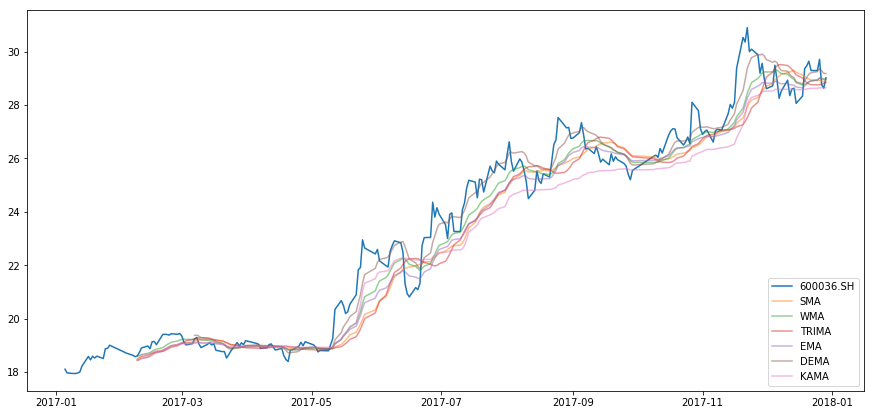

In [4]:
fig = plt.figure(figsize=(15, 7))
plt.plot(data['600036.SH'])
plt.plot(data['SMA'], alpha=0.5)
plt.plot(data['WMA'], alpha=0.5)
plt.plot(data['TRIMA'], alpha=0.5)
plt.plot(data['EMA'], alpha=0.5)
plt.plot(data['DEMA'], alpha=0.5)
plt.plot(data['KAMA'], alpha=0.5)
plt.legend(loc='lower right')
plt.show()

## 如何用均线构建策略？
**两条均线的三种交易方法**
1. 当均线金叉（短期大于长期均线）时候买进，死叉（短期小于长期）时卖出。 
2. 当价格上穿两条均线时买入，但价格下穿其中一条均线时卖出。 
3. 当两条均线都处于向上方向时买入，当两条均线都处于下跌方向时卖出。

In [3]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class MA1Strategy(CtaTemplate):
    className = 'MA1Strategy'
    author = 'xingetouzi'


    # 策略参数
    barPeriod = 200
    fastWindow = 18  # 快速均线参数
    slowWindow = 40  # 慢速均线参数
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    maTrend = {}  # 均线趋势，多头1，空头-1
    transactionPrice = {}

    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'barPeriod',
                 'fastWindow',
                 'slowWindow',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['transactionPrice',
               'maTrend']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(MA1Strategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(self.barPeriod)
        self.maTrend = {s: 0 for s in self.symbolList}
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        self.writeCtaLog(u'%s, bar.close%s, %s' % (symbol, bar.close, bar.datetime))  # 可以将实盘的运行情况记录到日志里

        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)) or \
                    self.maTrend[symbol] == -1:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

            # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)) or \
                    self.maTrend[symbol] == 1:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        self.putEvent()  # 每分钟更新一次UI界面

    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol

        am60 = self.getArrayManager(symbol, "60m")

        if not am60.inited:
            return

        # 计算均线并判断趋势
        fastMa = ta.SMA(am60.close, self.fastWindow)
        slowMa = ta.SMA(am60.close, self.slowWindow)

        if fastMa[-1] > slowMa[-1] and fastMa[-2] < slowMa[-2]:
            self.maTrend[symbol] = 1
        elif fastMa[-1] < slowMa[-1] and fastMa[-2] > slowMa[-2]:
            self.maTrend[symbol] = -1

        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            if self.maTrend[symbol] == 1:
                self.writeCtaLog('多头信号')
                self.buy(symbol, bar.close*1.02, self.lots)
            if self.maTrend[symbol] == -1:
                self.writeCtaLog('空头信号')
                self.short(symbol, bar.close*0.98, self.lots)

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MA1Strategy.onBar at 0x0000021CC23AD6A8>, <__main__.MA1Strategy object at 0x0000021CB4288C50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MA1Strategy.on60MinBar at 0x0000021CC23AD730>, <__main__.MA1Strategy object at 0x0000021CB4288C50>)
2018-11-24 12:48:24.126495	开始回测
2018-11-24 12:48:24.126495	策略初始化
2018-11-24 12:48:24.128495	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-24 12:48:58.475937	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 12:48:58.506902	载入完成，数据量：12000
2018-11-24 12:48:58.506902	策略初始化完成
2018-11-24 12:48:58.506902	策略启动完成
2018-11-24 12:48:58.507915	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-24 12:48:58.520921	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-24 12:49:37.867440	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 12:49:37.924410	载入完成，数据量：42270
2018-11-24 12:49:37.924410	当前回放数据:[201810

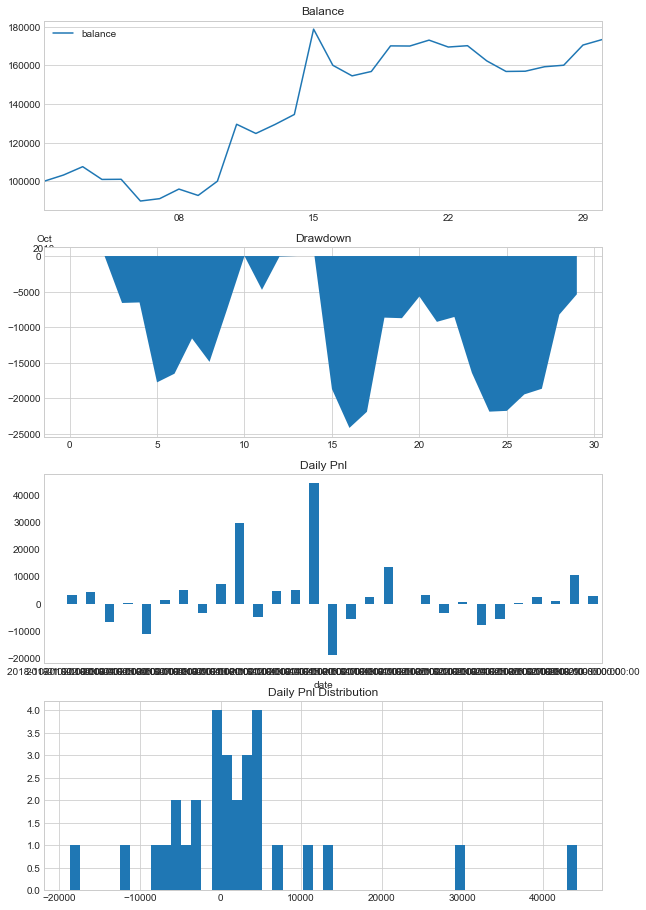

2018-11-24 12:51:07.464356	计算回测结果
2018-11-24 12:51:07.474332	交割单已生成
2018-11-24 12:51:07.474332	------------------------------
2018-11-24 12:51:07.474332	第一笔交易：	2018-10-04 14:00:00
2018-11-24 12:51:07.474332	最后一笔交易：	2018-10-30 23:58:00
2018-11-24 12:51:07.474332	总交易次数：	20
2018-11-24 12:51:07.474332	总盈亏：	73,040.72
2018-11-24 12:51:07.474332	最大回撤: 	-79,202.07
2018-11-24 12:51:07.475328	平均每笔盈利：	3,652.04
2018-11-24 12:51:07.475328	平均每笔滑点：	0.0
2018-11-24 12:51:07.475328	平均每笔佣金：	663.01
2018-11-24 12:51:07.475328	胜率		30.0%
2018-11-24 12:51:07.475328	盈利交易平均值	29,437.49
2018-11-24 12:51:07.475328	亏损交易平均值	-7,398.87
2018-11-24 12:51:07.475328	盈亏比：	3.98
2018-11-24 12:51:08.846295	策略回测统计图已保存


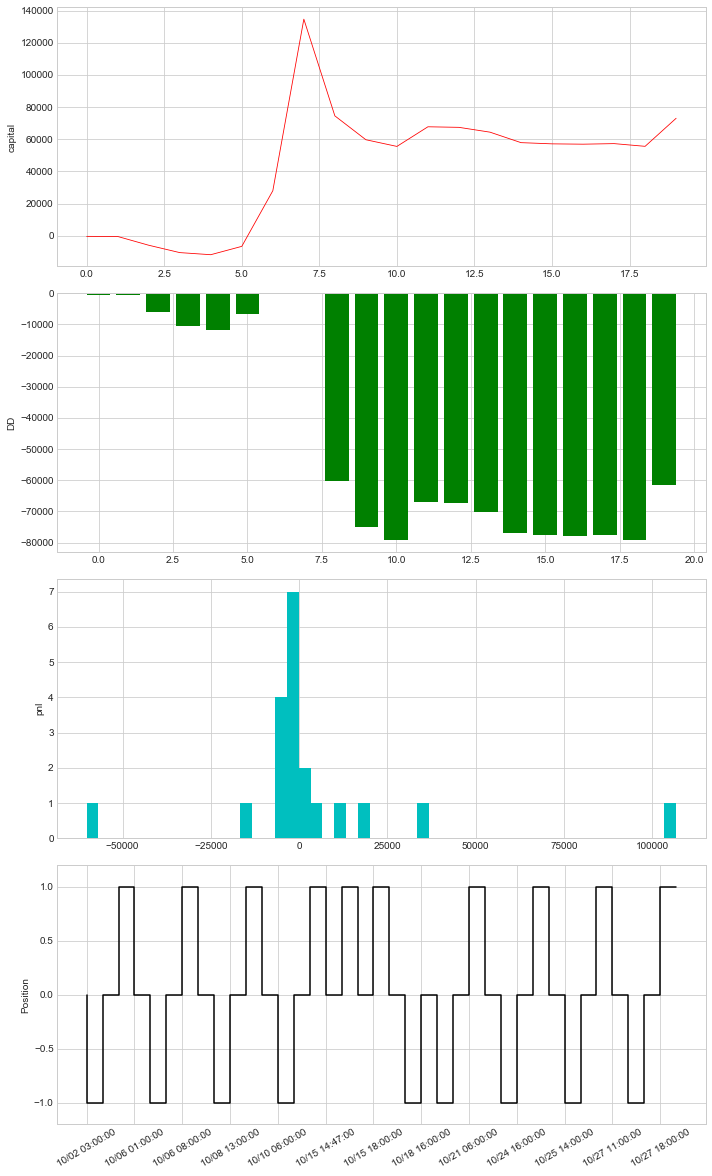

2018-11-24 12:51:09.797759	计算按日统计结果


In [4]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(MA1Strategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('MA1StrategyReport.xlsx')

In [5]:
#MA_Strategy_2
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class MA2Strategy(CtaTemplate):
    className = 'MA2Strategy'
    author = 'xingetouzi'


    # 策略参数
    barPeriod = 200
    fastWindow = 16  # 快速均线参数
    slowWindow = 40  # 慢速均线参数
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    maTrend = {}  # 均线趋势，多头1，空头-1
    stopLossControl = {}
    transactionPrice = {}

    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'symbolList',
                 'fastWindow',
                 'slowWindow',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'stopLossControl',
               'maTrend']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(MA2Strategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(self.barPeriod)
        self.maTrend = {s: 0 for s in self.symbolList}
        self.stopLossControl = {s: 0 for s in self.symbolList}
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        self.writeCtaLog(u'%s, bar.close%s, %s' % (symbol, bar.close, bar.datetime))  # 可以将实盘的运行情况记录到日志里

        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)) or \
                    self.maTrend[symbol] == -1:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
                self.stopLossControl = 1

            # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)) or \
                    self.maTrend[symbol] == 1:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.stopLossControl = -1

        self.putEvent()  # 每分钟更新一次UI界面

    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol

        am60 = self.getArrayManager(symbol, "60m")

        if not am60.inited:
            return

        # 计算均线并判断趋势
        fastMa = ta.SMA(am60.close, self.fastWindow)
        slowMa = ta.SMA(am60.close, self.slowWindow)
        if fastMa[-1] > slowMa[-1] and fastMa[-1] > fastMa[-2] and slowMa[-1] > slowMa[-2]:
            self.maTrend[symbol] = 1
        elif fastMa[-1] < slowMa[-1] and fastMa[-1] < fastMa[-2] and slowMa[-1] < slowMa[-2]:
            self.maTrend[symbol] = -1

    def on15MinBar(self, bar):
        """15分钟K线推送"""
        symbol = bar.vtSymbol

        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return

        # 计算均线并判断趋势
        fastMa = ta.SMA(am15.close, self.fastWindow)
        slowMa = ta.SMA(am15.close, self.slowWindow)

        crossOver = bar.close > slowMa[-1] and bar.close > fastMa[-1]

        crossDown = bar.close < slowMa[-1] or bar.close < fastMa[-1]

        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            if self.maTrend[symbol] == 1 and crossOver:
                self.writeCtaLog('多头信号')
                self.buy(symbol, bar.close*1.02, self.lots, priceType=PRICETYPE_LIMITPRICE)
            if self.maTrend[symbol] == -1 and crossDown:
                self.writeCtaLog('空头信号')
                self.short(symbol, bar.close*0.98, self.lots, priceType=PRICETYPE_LIMITPRICE)

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MA2Strategy.onBar at 0x0000021CCAEAE268>, <__main__.MA2Strategy object at 0x0000021CC6BB2748>)
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MA2Strategy.on60MinBar at 0x0000021CCAEAEA60>, <__main__.MA2Strategy object at 0x0000021CC6BB2748>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MA2Strategy.on15MinBar at 0x0000021CCAEAE488>, <__main__.MA2Strategy object at 0x0000021CC6BB2748>)
2018-11-24 12:52:25.353023	开始回测
2018-11-24 12:52:25.353023	策略初始化
2018-11-24 12:52:25.356020	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-24 12:52:57.454075	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 12:52:57.486067	载入完成，数据量：12000
2018-11-24 12:52:57.486067	策略初始化完成
2018-11-24 12:52:57.486067	策略启动完成
2018-11-24 12:52:57.486067	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-24 12:52:57.493065	载入历史数据。数据范围:[201

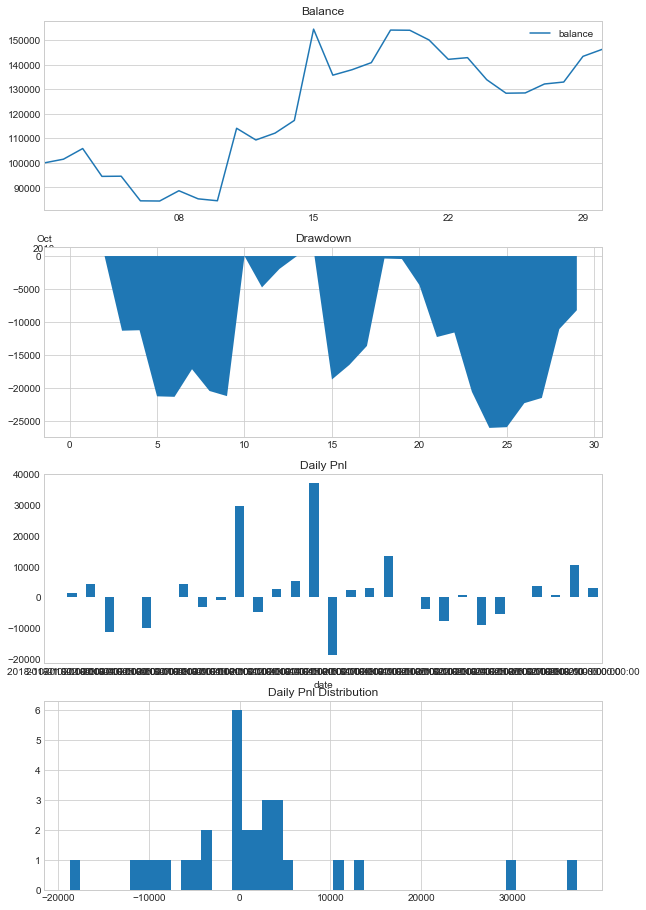

2018-11-24 12:55:48.240183	计算回测结果
2018-11-24 12:55:48.262171	交割单已生成
2018-11-24 12:55:48.263173	------------------------------
2018-11-24 12:55:48.263173	第一笔交易：	2018-10-02 02:00:00
2018-11-24 12:55:48.265193	最后一笔交易：	2018-10-30 23:58:00
2018-11-24 12:55:48.266169	总交易次数：	20
2018-11-24 12:55:48.266169	总盈亏：	45,886.33
2018-11-24 12:55:48.266169	最大回撤: 	-89,625.74
2018-11-24 12:55:48.267168	平均每笔盈利：	2,294.32
2018-11-24 12:55:48.267168	平均每笔滑点：	0.0
2018-11-24 12:55:48.267168	平均每笔佣金：	664.73
2018-11-24 12:55:48.267168	胜率		30.0%
2018-11-24 12:55:48.267168	盈利交易平均值	27,908.63
2018-11-24 12:55:48.267168	亏损交易平均值	-8,683.25
2018-11-24 12:55:48.267168	盈亏比：	3.21
2018-11-24 12:55:50.002181	策略回测统计图已保存


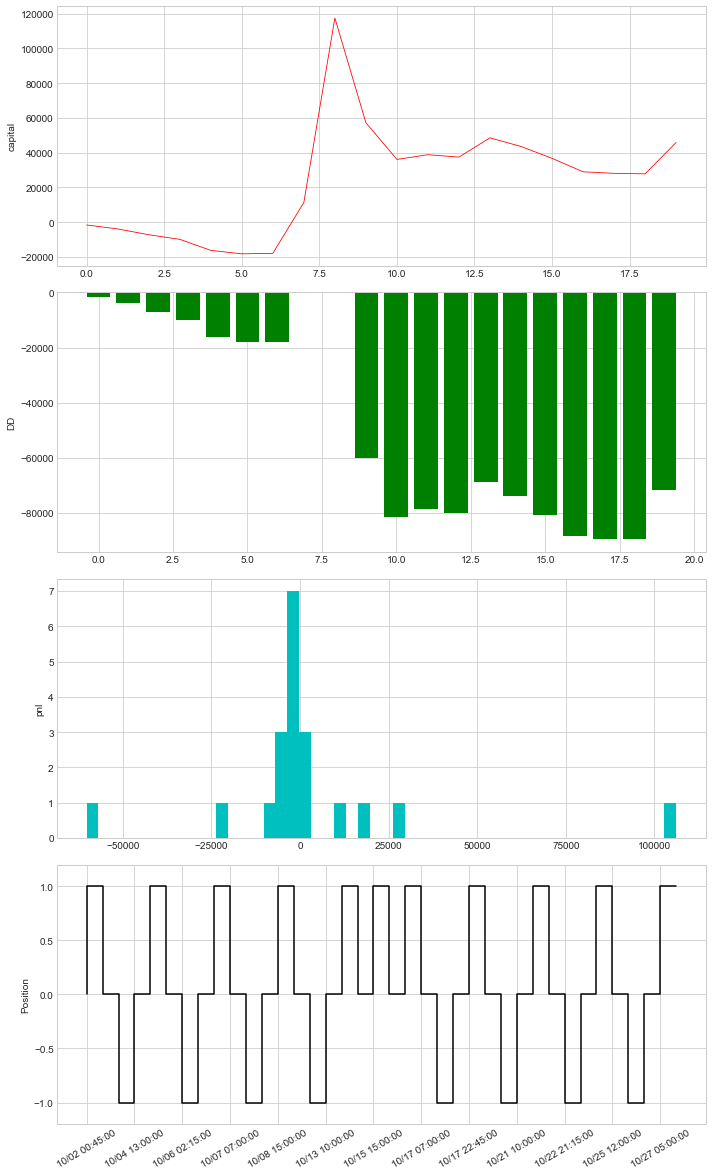

2018-11-24 12:55:50.936649	计算按日统计结果


In [6]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(MA2Strategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('MA2StrategyReport.xlsx')

In [7]:
#MA_Strategy_3

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class MA3Strategy(CtaTemplate):
    className = 'MA3Strategy'
    author = 'xingetouzi'


    # 策略参数
    barPeriod = 200
    fastWindow = 16  # 快速均线参数
    slowWindow = 40  # 慢速均线参数
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    maTrend = {}  # 均线趋势，多头1，空头-1
    stopLossControl = {}
    transactionPrice = {}

    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'symbolList',
                 'fastWindow',
                 'slowWindow',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'stopLossControl',
               'maTrend']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(MA3Strategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(self.barPeriod)
        self.maTrend = {s: 0 for s in self.symbolList}
        self.stopLossControl = {s: 0 for s in self.symbolList}
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        self.writeCtaLog(u'%s, bar.close%s, %s' % (symbol, bar.close, bar.datetime))  # 可以将实盘的运行情况记录到日志里

        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)) or \
                    self.maTrend[symbol] == -1:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
                self.stopLossControl = 1

            # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)) or \
                    self.maTrend[symbol] == 1:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.stopLossControl = -1

        self.putEvent()  # 每分钟更新一次UI界面

    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol

        am60 = self.getArrayManager(symbol, "60m")

        if not am60.inited:
            return

        # 计算均线并判断趋势
        fastMa = ta.SMA(am60.close, self.fastWindow)
        slowMa = ta.SMA(am60.close, self.slowWindow)

        if slowMa[-1] > slowMa[-2] and fastMa[-1] > fastMa[-2]:
            self.maTrend[symbol] = 1
        elif slowMa[-1] < slowMa[-2] and fastMa[-1] < fastMa[-2]:
            self.maTrend[symbol] = -1

        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            if self.maTrend[symbol] == 1:
                self.writeCtaLog('多头信号')
                self.buy(symbol, bar.close*1.02, self.lots, priceType=PRICETYPE_LIMITPRICE)
            if self.maTrend[symbol] == -1:
                self.writeCtaLog('空头信号')
                self.short(symbol, bar.close*0.98, self.lots, priceType=PRICETYPE_LIMITPRICE)

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MA3Strategy.onBar at 0x0000021CC422B510>, <__main__.MA3Strategy object at 0x0000021CC65B9BE0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MA3Strategy.on60MinBar at 0x0000021CC422BEA0>, <__main__.MA3Strategy object at 0x0000021CC65B9BE0>)
2018-11-24 13:02:20.984556	开始回测
2018-11-24 13:02:20.984556	策略初始化
2018-11-24 13:02:20.987553	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-24 13:02:54.430976	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:02:54.473952	载入完成，数据量：12000
2018-11-24 13:02:54.474951	策略初始化完成
2018-11-24 13:02:54.477950	策略启动完成
2018-11-24 13:02:54.478947	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:02:54.487941	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:03:32.583741	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:03:32.652576	载入完成，数据量：42270
2018-11-24 13:03:32.653574	当前回放数据:[201810

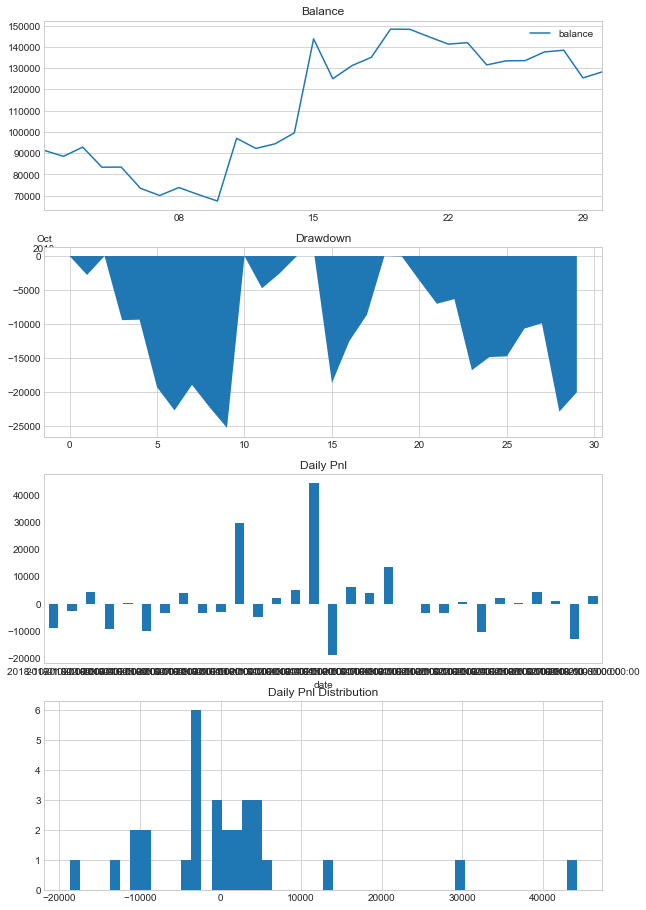

2018-11-24 13:04:59.622615	计算回测结果
2018-11-24 13:04:59.638605	交割单已生成
2018-11-24 13:04:59.638605	------------------------------
2018-11-24 13:04:59.638605	第一笔交易：	2018-10-01 19:00:00
2018-11-24 13:04:59.638605	最后一笔交易：	2018-10-30 23:58:00
2018-11-24 13:04:59.638605	总交易次数：	29
2018-11-24 13:04:59.638605	总盈亏：	27,888.46
2018-11-24 13:04:59.639605	最大回撤: 	-74,267.72
2018-11-24 13:04:59.639605	平均每笔盈利：	961.67
2018-11-24 13:04:59.640604	平均每笔滑点：	0.0
2018-11-24 13:04:59.640604	平均每笔佣金：	660.67
2018-11-24 13:04:59.640604	胜率		24.14%
2018-11-24 13:04:59.640604	盈利交易平均值	22,372.29
2018-11-24 13:04:59.640604	亏损交易平均值	-5,850.8
2018-11-24 13:04:59.640604	盈亏比：	3.82
2018-11-24 13:05:00.765207	策略回测统计图已保存


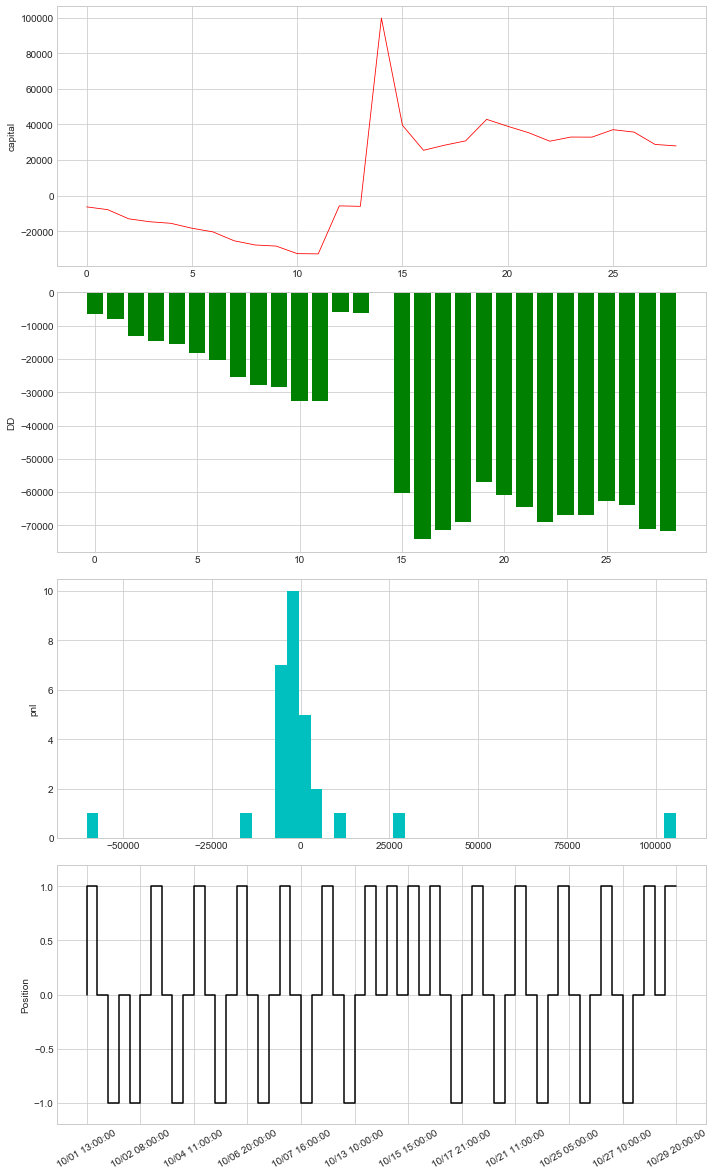

2018-11-24 13:05:01.766637	计算按日统计结果


In [8]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(MA3Strategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('MA3StrategyReport.xlsx')

## 作业：
更换标的与均线类型回测策略。